# Sensitivity code tutorial

This notebook is intended to demonstrate how the python-based sensitivity code works, and how one can run it. It is not intended to be used for a full calculation -- full calculations should be written up into a script and run in many parallel jobs on a cluster. Instead, this document is intended to walk you through a calculation start-to-finish, and show you what each step is doing. If there is something that is not explained well, or could be better documented, feel free to get in touch: blenardo@stanford.edu

## Definitions/glossary

There are a few words that have very specific meanings in the context of the sensitivity code.  We define them here:
* **Component:** A "component" is a specific material/isotope pair. For instance, "Field Ring U238" is a single component. Each component has an associated specific activity, mass, and PDF.
* **PDF:** This stands for "probability density function," and in our context means the distribution in energy/standoff/whatever-space for events from a certain component. PDFs are generated using the processed (clustered & reconstructed) output from the Geant4 simulations.
* **Material:** A "material" is exactly what it sounds like: copper, silicon, Al, etc. 
* **Isotope:** The parent isotope which produces the background PDF. For example, any backgrounds from the Th232 decay chain for a given material will be lumped together, and the events will all be contained in a PDF with the isotope Th232.
* **Group:** A "group" is defined as a grouping of multiple components, with a single PDF corresponding to the weighted sum of each of the component PDFs. Generally, we'd like to form groups of components with similarly-shaped distributions, to avoid degeneracies in our fits. 
* **Livetime:** Our assumption for how long the experiment will run
* **Specific Activity:** How many decays of a given isotope we will get per unit mass of the material. These values come from assay measurements.
* **Mass:** Mass of the component in kg. Used in conjunction with Specific Activity to determine the weight (meaning number of counts) of the PDF for each component. 
* **Weight:** Here, the word "weight" does not refer to a physical property, but rather a coefficient that scales the PDF to the appropriate number of counts that we expect to see in our experiment.
* **Hit Efficiency:** This isn't actually used in the sensitivity code, but is stored in the Materials Spreadsheet nonetheless; it quantifies what fraction of decays from a given component create an event in a specific energy region (e.g. the FWHM ROI) and mass (e.g. the inner two tons)



## Import relevant libraries

First, of course, we need to import the relevant libraries. The nEXO-specific python classes are contained in the directory: 
<code>sensitivity/modules</code>
To correctly import them, you'll need to append this directory to python's search path, as below.


In [6]:
# Import sys, then tell python where to find the nEXO-specific classes

import sys
!pwd
sys.path.append('../modules')

/Users/brianlenardo/Research/nEXO/sensitivity/work


In [7]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt

In [8]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

In [15]:
df = pd.read_hdf('../tables/SimulationHistograms_D-005_v22_2018-11-12_02_04.h5')
df.head()

,Filename,PDF,PDFAxisNames
0,MC-083_Sens_Th232_HFE.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"
1,MC-080_Sens_Th232_ActiveSiPM.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"
2,MC-083_Sens_Co60_HFE.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"
3,MC-095_Sens_U238_Bulge.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"
4,MC-076_Sens_U238_SiPMModule.root,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]"


## OPTIONAL: Converting the Excel spreadsheet and ROOT pdfs to HDF5 file formats.

The Materials Spreadsheet is a document stored in the Materials Database, which contains relevant information of the activities, masses, and Geant4 hit efficiencies. To feed it into the sensitivity code, we need to parse the spreadsheet and turn it into a more readily machine-readable format. Here we accomplish this using a script called ```ConvertExcel2DataFrame.py``` contained in ```sensitivity/work/```. This script uses the Pandas python library to read and then store the information in the spreadsheet.

The 



In [4]:
%run ConvertExcel2DataFrame.py \
        ../tables/Summary_D-005_v22_2018-11-12_02.xls \
        ../tables/Summary_D-005_v22_2018-11-12_02_tutorial.h5 \
        ../tables/SimulationPDFs_D-005_v22_2018-11-12_02_04.h5

Loading sheets...
	Reading SpecificActivities...
	Reading DetectorSpecifications...
	Reading SS_ExpectedCounts
	Reading MS_ExpectedCounts
	Reading MC_RawCounts_SS_Integrals
	Reading MC_RawCounts_MS_Integrals
Sheets loaded.
Component: Outer Cryostat Support (Resin)	 Isotope: U-238	 MC_ID: MC-089
Component: Outer Cryostat Support (Resin)	 Isotope: Th-232	 MC_ID: MC-089
Component: Outer Cryostat Support (Resin)	 Isotope: K-40	 MC_ID: MC-089
Component: Outer Cryostat Support (Resin)	 Isotope: Co-60	 MC_ID: MC-089
Component: Outer Cryostat Support (Fiber)	 Isotope: U-238	 MC_ID: MC-089
Component: Outer Cryostat Support (Fiber)	 Isotope: Th-232	 MC_ID: MC-089
Component: Outer Cryostat Support (Fiber)	 Isotope: K-40	 MC_ID: MC-089
Component: Outer Cryostat Support (Fiber)	 Isotope: Co-60	 MC_ID: MC-089
Component: Outer Cryostat (Resin)	 Isotope: U-238	 MC_ID: MC-089


/Users/brianlenardo/Research/nEXO/sensitivity/work/ConvertExcel2DataFrame.py:217: RuntimeWarning: invalid value encountered in sqrt
  thispdf['Expected Counts Err'] = np.sqrt( thispdf['Expected Counts'] ) #thisrowSS['Error'].iloc[0] + thisrowMS['Error'].iloc[0]


Component: Outer Cryostat (Resin)	 Isotope: Th-232	 MC_ID: MC-089
Component: Outer Cryostat (Resin)	 Isotope: K-40	 MC_ID: MC-089
Component: Outer Cryostat (Resin)	 Isotope: Co-60	 MC_ID: MC-089
Component: Outer Cryostat (Fiber)	 Isotope: U-238	 MC_ID: MC-089
Component: Outer Cryostat (Fiber)	 Isotope: Th-232	 MC_ID: MC-089
Component: Outer Cryostat (Fiber)	 Isotope: K-40	 MC_ID: MC-089
Component: Outer Cryostat (Fiber)	 Isotope: Co-60	 MC_ID: MC-089
Component: Inner Cryostat Support (Resin)	 Isotope: U-238	 MC_ID: MC-096
Component: Inner Cryostat Support (Resin)	 Isotope: Th-232	 MC_ID: MC-096
Component: Inner Cryostat Support (Resin)	 Isotope: K-40	 MC_ID: MC-096
Component: Inner Cryostat Support (Resin)	 Isotope: Co-60	 MC_ID: MC-096
Component: Inner Cryostat Support (Fiber)	 Isotope: U-238	 MC_ID: MC-096
Component: Inner Cryostat Support (Fiber)	 Isotope: Th-232	 MC_ID: MC-096
Component: Inner Cryostat Support (Fiber)	 Isotope: K-40	 MC_ID: MC-096
Component: Inner Cryostat Support 

Elapsed time = 9.801786184310913 seconds (0.16336310307184856 minutes).


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['PDFName', 'Component', 'Isotope', 'MC ID', 'Histogram', 'HistogramAxisNames', 'Activity ID', 'TotalHitEff_N', 'Group']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Creating a workspace

The ```workspace``` class is a container that stores all of the various sub-objects that are required for the sensitivity calculation. These include:

* **df_input**, which is a pandas-dataframe version of the Materials Spreadsheet from the Materials Database. This contains details for every component in the detector, including specific activities and masses, which we need to generate an overall event distribution.
* **df_group_pdfs**, which is a pandas dataframe containing the PDFs for each group that we'll use in the fit.
* **neg_log_likelihood**, which is the object that contains the likelihood function and a list of the free parameters in the fit.
* **minimizer**, which is the minimizer (we currently use iMinuit)
* **livetime**, a variable storing the number of seconds that we expect the experiment to run
* **histogram_axis_names**, which is a list storing the names of each dimension in the fit (e.g. "energy", "standoff", etc.)

The ```workspace``` also has methods to populate the sub-objects.


Below, we create a workspace, then load in the input dataframe and grouped PDFs from files generated by the materials database.


In [10]:
workspace = nEXOFitWorkspace.nEXOFitWorkspace()

In [11]:
workspace.LoadInputDataframe('../tables/Summary_D-005_v22_2018-11-12_02_tutorial.h5')


Loading input data from materials database spreadsheet....

Loaded dataframe with 130 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Histogram
	HistogramAxisNames
	Total Mass or Area
	Halflife
	SpecActiv
	SpecActivErr
	RawActiv
	RawActivErr
	Activity ID
	Expected Counts
	Expected Counts Err
	Expected Counts UL
	TotalHitEff_N
	TotalHitEff_K
	Group

Fit variables:
	['SS/MS', 'Energy (keV)', 'Standoff (mm)']


In [13]:
workspace.CreateGroupedPDFs()


Creating grouped PDFs....

	Group:     	Expected Counts:
	Far        	        4882.22
	VesselU-238 	       19053.03
	VesselTh-232 	        2169.26
	Off        	      754245.90
	InternalU-238 	       39901.84
	InternalTh-232 	        7703.98
	FullTpcCo-60 	           0.45
	FullTpcK-40 	    31965349.11
	Rn-222     	        9107.27
	FullLXeBb2n 	    27949377.02
	FullLXeBb0n 	           0.00
	Xe-137     	          46.52
	Total Sum  	    59992708.48


In [14]:
# Check and make sure any component is normalized to one total count.
h_intu238 = workspace.df_group_pdfs['Histogram'].loc[ \
                      workspace.df_group_pdfs['Group']=='InternalU-238' ].values[0]
print(h_intu238)
workspace.df_group_pdfs.head()

Hist(2 bins in [0,2], 280 bins in [700.0,3500.0], 25 bins in [0.0,650.0]) with sum 0.9999999999999999, 7709 empty bins, and 0 non-finite values


,Group,Histogram,TotalExpectedCounts
0,Far,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",4882.22
1,VesselU-238,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",19053
2,VesselTh-232,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",2169.26
3,Off,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",754246
4,InternalU-238,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",39901.8


In [18]:
model = nEXOFitModel.nEXOFitModel()

In [19]:
model.AddHistogramsFromDataframe( workspace.df_group_pdfs )

In [20]:
initial_model = model.GenerateModelDistribution()

In [21]:
fake_data = model.GenerateDataset()

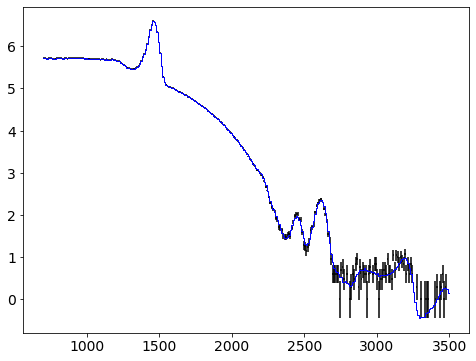

In [22]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots (1, 1, figsize=(8, 6))

hl.plot1d(ax, initial_model.project([1]).log10(),color=(0.,0.,1.),linewidth=1)
hl.plot1d(ax, fake_data.project([1]).log10(),color=(0.,0.,0.), crosses=True)

In [23]:
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()

In [24]:
likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs)
initial_guess = np.ones(len(likelihood.variable_list))
for i in range(len(likelihood.variable_list)):
    initial_guess[i] = (likelihood.variable_list[i]['Value'])
print(initial_guess)

[1.90530261e+04 2.16925971e+03 3.99018437e+04 7.70398482e+03
 4.47709845e-01 3.19653491e+07 9.10726717e+03 2.79493770e+07
 1.00000000e-04 4.65166535e+01]


In [25]:
likelihood.AddDataset( likelihood.model_obj.GenerateDataset() )

In [26]:
variable_values = np.ones(len(likelihood.variable_list))
for i in range(0,len(variable_values)):
    variable_values[i] = likelihood.variable_list[i]['Value']

In [27]:
print(likelihood.variable_list[-2]['Name'])

Num_FullLXeBb0n


In [28]:
from iminuit import Minuit

In [29]:
def NegLogLikelihood(parameter_values):
    return likelihood.ComputeNegLogLikelihood(parameter_values)

In [30]:
initial_values = initial_guess
variable_names = tuple(var['Name'] for var in likelihood.initial_values)
error_tuple = tuple( 0.02*var['Value'] for var in likelihood.initial_values )
par_fix_list = [ False for i in range(len(likelihood.initial_values)) ]
#par_fix_list[-2] = True
par_fix_tuple = tuple( x for x in par_fix_list )


m = Minuit.from_array_func( NegLogLikelihood, \
                            initial_values, \
                            error=error_tuple, \
                            fix=par_fix_tuple, \
                            name=variable_names, \
                            errordef = 0.5 )
m.get_param_states()

--------------------------------------------------------------------------------------------------------
|   | Name               |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------------------
| 0 | Num_VesselU-238    |  1.91E4   |  0.04E4   |            |            |         |         |       |
| 1 | Num_VesselTh-232   |   2170    |    40     |            |            |         |         |       |
| 2 | Num_InternalU-238  |  0.399E5  |  0.008E5  |            |            |         |         |       |
| 3 | Num_InternalTh-232 |  0.770E4  |  0.015E4  |            |            |         |         |       |
| 4 | Num_FullTpcCo-60   |   0.448   |   0.009   |            |            |         |         |       |
| 5 | Num_FullTpcK-40    |  0.320E8  |  0.006E8  |            |            |         |         |       |
| 6 | Num_Rn-222         |  0.911E4  |  0.018E4  |            |            |         |         |       |
| 7 | Num_FullLXeBb2n    |  2.79E7   |  0.06E7   |            |            |         |         |       |
| 8 | Num_FullLXeBb0n    | 1.000E-4  | 0.020E-4  |            |            |         |         |       |
| 9 | Num_Xe-137         |   46.5    |    0.9    |            |            |         |         |       |
--------------------------------------------------------------------------------------------------------

In [31]:
m.migrad()

------------------------------------------------------------------
| FCN = -6.499E+04              |     Ncalls=436 (436 total)     |
| EDM = 5.59E-06 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
|   | Name               |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------------------
| 0 | Num_VesselU-238    |   2.0E4   |   0.4E4   |            |            |         |         |       |
| 1 | Num_VesselTh-232   |   2600    |    500    |            |            |         |         |       |
| 2 | Num_InternalU-238  |  0.46E5   |  0.04E5   |            |            |         |         |       |
| 3 | Num_InternalTh-232 |  0.72E4   |  0.06E4   |            |            |         |         |       |
| 4 | Num_FullTpcCo-60   |   -1800   |    1800   |            |            |         |         |       |
| 5 | Num_FullTpcK-40    |  0.320E8  |  0.000E8  |            |            |         |         |       |
| 6 | Num_Rn-222         |  0.65E4   |  0.14E4   |            |            |         |         |       |
| 7 | Num_FullLXeBb2n    |  2.794E7  |  0.001E7  |            |            |         |         |       |
| 8 | Num_FullLXeBb0n    |   0.04    |   6.61    |            |            |         |         |       |
| 9 | Num_Xe-137         |    57     |    25     |            |            |         |         |       |
--------------------------------------------------------------------------------------------------------

In [32]:
nll_best = m.fval

par_values_best = np.array([value for key,value in m.values.items()])

print(nll_best)
print(par_values_best)

-64988.639394283295
[ 2.00098723e+04  2.55487456e+03  4.57871031e+04  7.22527937e+03
 -1.81568481e+03  3.19658153e+07  6.48205267e+03  2.79446053e+07
  4.35279690e-02  5.70317477e+01]


In [33]:
num_datasets = 200
num_hypotheses = 15
xvals = np.linspace(0,28,15)
lambdas = np.zeros((num_datasets,num_hypotheses))
converged = np.ones(num_datasets,dtype=bool)


In [34]:
import time

start = time.time()

for j in range(0,num_datasets):
    print('Running dataset {}'.format(j))
    likelihood.model_obj.UpdateVariables(initial_guess)
    likelihood.model_obj.GenerateModelDistribution()
    likelihood.AddDataset( likelihood.model_obj.GenerateDataset() )

    initial_values = np.copy(initial_guess)
    variable_names = tuple(var['Name'] for var in likelihood.initial_values)
    error_tuple = tuple( 0.02*var['Value'] for var in likelihood.initial_values )
    par_fix_list = [ False for i in range(len(likelihood.initial_values)) ]
    #par_fix_list[-2] = True
    par_fix_tuple = tuple( x for x in par_fix_list )


    m = Minuit.from_array_func( NegLogLikelihood, \
                            initial_values, \
                            error=error_tuple, \
                            fix=par_fix_tuple, \
                            name=variable_names, \
                            errordef = 0.5 )
    m.migrad()
    nll_best = m.fval
    if not m.get_fmin()['is_valid']:
        converged[j] = False
    
    
    for i in (range(0,num_hypotheses)):
        
        initial_values = np.copy(initial_guess)
        initial_values[-2] = float(i)*2.+0.000001
        variable_names = tuple(var['Name'] for var in likelihood.initial_values)
        error_tuple = tuple( 0.02*var['Value'] for var in likelihood.initial_values )
        par_fix_list = [ False for i in range(len(likelihood.initial_values)) ]
        par_fix_list[-2] = True
        par_fix_tuple = tuple( x for x in par_fix_list )
    

        m = Minuit.from_array_func( NegLogLikelihood, \
                            initial_values, \
                            error=error_tuple, \
                            fix=par_fix_tuple, \
                            name=variable_names, \
                            errordef = 0.5 )
        m.migrad()
        lambdas[j,i] = 2*(m.fval - nll_best)
        if not m.get_fmin()['is_valid']:
            converged[j] = False
            
print('Elapsed: {:4.4}s'.format(time.time()-start))

Running dataset 0
Running dataset 1
Running dataset 2
Running dataset 3
Running dataset 4
Running dataset 5
Running dataset 6
Running dataset 7
Running dataset 8
Running dataset 9
Running dataset 10
Running dataset 11
Running dataset 12
Running dataset 13
Running dataset 14
Running dataset 15
Running dataset 16
Running dataset 17
Running dataset 18
Running dataset 19
Elapsed: 463.5s


Num converged: 17


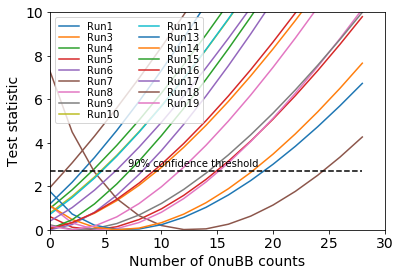

In [49]:
for i in range(0,20):
    if converged[i]:
        plt.plot(xvals,lambdas[i],'-',label='Run{}'.format(i))
plt.plot(xvals,np.ones(len(xvals))*2.706,'--k')
plt.text(7.,2.9,'90% confidence threshold',fontsize=10)
plt.axis([0.,30.,0.,10.])
plt.legend(loc='upper left',fontsize=10,ncol=2,labelspacing=0.1)
plt.ylabel('Test statistic')
plt.xlabel('Number of 0nuBB counts')
print('Num converged: {}'.format(np.sum(converged)))

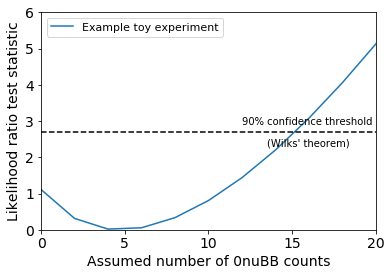

In [46]:
plt.plot(xvals,lambdas[8],'-',label='Example toy experiment')
plt.plot(xvals,np.ones(len(xvals))*2.706,'--k')
plt.text(12.,2.9,'90% confidence threshold',fontsize=10)
plt.text(13.5,2.3,'(Wilks\' theorem)',fontsize=10)
plt.axis([0.,20.,0.,6.])
plt.legend(loc='upper left',fontsize=11,ncol=2,labelspacing=0.1)
plt.ylabel('Likelihood ratio test statistic')
plt.xlabel('Assumed number of 0nuBB counts')
plt.savefig('example_toy_experiment_test_statistic.png',dpi=400,bbox_inches='tight')

In [47]:
crossings = np.zeros(20)

for i in range(0,20):
    if converged[i]:
        p = np.polyfit(xvals,lambdas[i],2.)
        crossings[i] = (-p[1] + np.sqrt( p[1]**2 - 4*(p[0])*(p[2]-2.706) ))/(2*p[0])




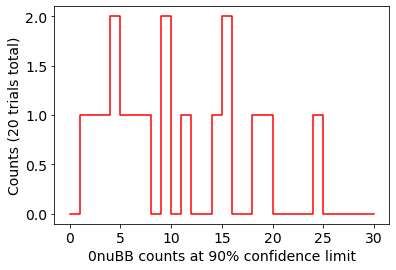

In [48]:
fig,ax = plt.subplots(1,1)
hteststats = hl.hist(crossings[crossings>0.],bins=np.linspace(0,30,31))
hl.plot1d(ax,hteststats,color='r')
ax.set_ylabel('Counts (20 trials total)')
ax.set_xlabel('0nuBB counts at 90% confidence limit')
plt.savefig('example_sensitivity_distribution.png',dpi=400,bbox_inches='tight')

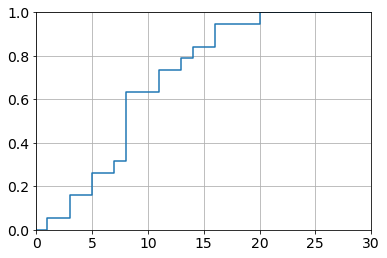

In [30]:
hcdf = hl.Hist(hteststats.bins,np.cumsum(hteststats.values)/np.sum(hteststats.values))
hl.plot1d(hcdf)
plt.axis([0.,30.,0.,1.])
plt.grid()

In [31]:
initial_model

Hist(2 bins in [0,2], 280 bins in [700.0,3500.0], 25 bins in [0.0,650.0]) with sum 59992708.47556864, 1918 empty bins, and 0 non-finite values

In [32]:
df_variables = pd.DataFrame(columns=['PDF','Value','Function'])

df_variables = df_variables.append({'PDF':'Initial Model','Value':10.,'Function': lambda pdf, norm: norm*pdf},ignore_index=True)

In [33]:
parameter = lambda pdf,norm: norm*pdf
df_variables.head()

,PDF,Value,Function
0,Initial Model,10.0,<function <lambda> at 0x12d8f1400>


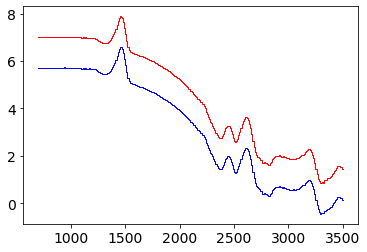

In [34]:
scaledhist = df_variables['Function'].iloc[0](initial_model,20.)

hl.plot1d(initial_model.project([1]).log10(),color=(0.,0.,1.),linewidth=1)
hl.plot1d(scaledhist.project([1]).log10(),color=(1.,0.,0.),linewidth=1)
